In [317]:
import pandas as pd
import numpy as np
import re
# --------------------
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
import math
import unidecode 

In [318]:
df = pd.read_csv('data_defi3.csv.gz',compression="gzip", sep=";")

In [319]:
print(df.info())
print(df['PLT'].unique())
print(df['PLT'].nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23514 entries, 0 to 23513
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Libellé.Prescription  23514 non-null  object 
 1   Avis.Pharmaceutique   23141 non-null  object 
 2   PLT                   23514 non-null  float64
dtypes: float64(1), object(2)
memory usage: 551.2+ KB
None
[ 5.3  4.1  3.1 10.   1.2  1.1  5.1  8.5  6.4  2.2 11.   8.4  6.2  4.2
  9.1  8.1  8.3  6.1  3.2  2.4  8.2  5.2  1.3  2.1  6.3  7. ]
26


In [320]:
df.dropna(inplace=True)

In [321]:
df.head()

,Libellé.Prescription,Avis.Pharmaceutique,PLT
0,"CONTRAMAL 100 MG/ML, GOUTTES BUV (TRAMADOL)",30/12/16 pas d'indication,5.3
1,"IMOVANE 7.5 MG, CPR SÉCABLE (ZOPICLONE)","22/12/16 recommandé -> IMOVANE 3,75MG CP, 1 au...",4.1
2,"COLCHICINE 1 MG, CPR SÉCABLE (COLCHICINE)","au vue de la DFG, il est recommandé d'administ...",4.1
3,"PANTOPRAZOLE 40 MG, CPR GASTRO-RÉSISTANT (EUPA...",Dose curative et absence d'ATCD gastrique retr...,4.1
4,VANCOMYCINE 500 mg 1x/j,posologie infraT veuillez réévaluer la posolog...,3.1


In [322]:
#unaccented_string = unidecode.unidecode(df['Avis.Pharmaceutique'][2])
df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x : unidecode.unidecode(x)) # Remove é etc and ponctuation

In [323]:
chars = [4,4.1,4.2,5,5.1,5.2,5.3,6.3,6.4]
for x in df['PLT']:
    if x not in chars:
        df['PLT'].replace(x, 0,inplace=True)
for c in chars:
    df['PLT'].replace(c, 1,inplace=True)

In [324]:
df['Length'] = df['Avis.Pharmaceutique'].str.len()

In [325]:
df.groupby('PLT').describe()

Length                                                     
       count       mean        std  min   25%   50%    75%    max
PLT                                                              
0.0  18613.0  81.381722  42.408490  2.0  51.0  73.0  102.0  455.0
1.0   4528.0  88.431316  49.519892  6.0  54.0  75.0  115.0  323.0

<AxesSubplot:ylabel='Frequency'>

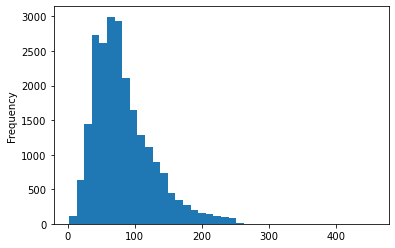

In [326]:
df['Length'].plot(bins=40, kind='hist') 

In [40]:
df['PLT'] = df['PLT'].apply(lambda x : math.floor(x))

In [327]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [328]:
df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x : preprocess_text(x))
df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].str.lower()

In [329]:
stop_word = ["a","abord","absolument","afin","ah","ai","aie","aient","aies","ailleurs","ainsi","ait","allaient",
             "allo","allons","allô","alors","anterieur","anterieure","anterieures","apres","après","as","assez",
             "attendu","au","aucun","aucune","aucuns","aujourd","aujourd'hui","aupres","auquel","aura","aurai",
             "auraient","aurais","aurait","auras","aurez","auriez","aurions","aurons","auront","aussi","autant",
             "autre","autrefois","autrement","autres","autrui","aux","auxquelles","auxquels","avaient","avais",
             "avait","avant","avec","avez","aviez","avions","avoir","avons","ayant","ayez","ayons","b","bah",
             "bas","basee","bat","beau","beaucoup","bien","bigre","bon","boum","bravo","brrr","c","car","ce",
             "ceci","cela","celle","celle-ci","celle-là","celles","celles-ci","celles-là","celui","celui-ci",
             "celui-là","celà","cent","cependant","certain","certaine","certaines","certains","certes","ces",
             "cet","cette","ceux","ceux-ci","ceux-là","chacun","chacune","chaque","cher","chers","chez","chiche",
             "chut","chère","chères","ci","cinq","cinquantaine","cinquante","cinquantième","cinquième","clac","clic",
             "combien","comme","comment","comparable","comparables","compris","concernant","contre","couic",
             "crac","d","da","dans","de","debout","dedans","dehors","deja","delà","depuis","dernier","derniere",
             "derriere","derrière","des","desormais","desquelles","desquels","dessous","dessus","deux","deuxième",
             "deuxièmement","devant","devers","devra","devrait","different","differentes","differents","différent",
             "différente","différentes","différents","dire","directe","directement","dit","dite","dits","divers",
             "diverse","diverses","dix","dix-huit","dix-neuf","dix-sept","dixième","doit","doivent","donc","dont",
             "dos","douze","douzième","dring","droite","du","duquel","durant","dès","début","désormais","e","effet",
             "egale","egalement","egales","eh","elle","elle-même","elles","elles-mêmes","en","encore","enfin","entre","envers","environ","es","essai","est","et","etant","etc","etre","eu","eue","eues","euh","eurent","eus","eusse","eussent","eusses","eussiez","eussions","eut","eux","eux-mêmes","exactement","excepté","extenso","exterieur","eûmes","eût","eûtes","f","fais","faisaient","faisant","fait","faites","façon","feront","fi","flac","floc","fois","font","force","furent","fus","fusse","fussent","fusses","fussiez","fussions","fut","fûmes","fût","fûtes","g","gens","h","ha","haut","hein","hem","hep","hi","ho","holà","hop","hormis","hors","hou","houp","hue","hui","huit","huitième","hum","hurrah","hé","hélas","i","ici","il","ils","importe","j","je","jusqu","jusque","juste","k","l","la","laisser","laquelle","las","le","lequel","les","lesquelles","lesquels","leur","leurs","longtemps","lors","lorsque","lui","lui-meme","lui-même","là","lès","m","ma","maint","maintenant","mais","malgre","malgré","maximale","me","meme","memes","merci","mes","mien","mienne","miennes","miens","mille","mince","mine","minimale","moi","moi-meme","moi-même","moindres","moins","mon","mot","moyennant","multiple","multiples","même","mêmes","n","na","naturel","naturelle","naturelles","ne","neanmoins","necessaire","necessairement","neuf","neuvième","ni","nombreuses","nombreux","nommés","non","nos","notamment","notre","nous","nous-mêmes","nouveau","nouveaux","nul","néanmoins","nôtre","nôtres","o","oh","ohé","ollé","olé","on","ont","onze","onzième","ore","ou","ouf","ouias","oust","ouste","outre","ouvert","ouverte","ouverts","o|","où","p","paf","pan","par","parce","parfois","parle","parlent","parler","parmi","parole","parseme","partant","particulier","particulière","particulièrement","pas","passé","pendant","pense","permet","personne","personnes","peu","peut","peuvent","peux","pff","pfft","pfut","pif","pire","pièce","plein","plouf","plupart","plus","plusieurs","plutôt","possessif","possessifs","possible","possibles","pouah","pour","pourquoi","pourrais","pourrait","pouvait","prealable","precisement","premier","première","premièrement","pres","probable","probante","procedant","proche","près","psitt","pu","puis","puisque","pur","pure","q","qu","quand","quant","quant-à-soi","quanta","quarante","quatorze","quatre","quatre-vingt","quatrième","quatrièmement","que","quel","quelconque","quelle","quelles","quelqu'un","quelque","quelques","quels","qui","quiconque","quinze","quoi","quoique","r","rare","rarement","rares","relative","relativement","remarquable","rend","rendre","restant","reste","restent","restrictif","retour","revoici","revoilà","rien","s","sa","sacrebleu","sait","sans","sapristi","sauf","se","sein","seize","selon","semblable","semblaient","semble","semblent","sent","sept","septième","sera","serai","seraient","serais","serait","seras","serez","seriez","serions","serons","seront","ses","seul","seule","seulement","si","sien","sienne","siennes","siens","sinon","six","sixième","soi","soi-même","soient","sois","soit","soixante","sommes","son","sont","sous","souvent","soyez","soyons","specifique","specifiques","speculatif","stop","strictement","subtiles","suffisant","suffisante","suffit","suis","suit","suivant","suivante","suivantes","suivants","suivre","sujet","superpose","sur","surtout","t","ta","tac","tandis","tant","tardive","te","tel","telle","tellement","telles","tels","tenant","tend","tenir","tente","tes","tic","tien","tienne","tiennes","tiens","toc","toi","toi-même","ton","touchant","toujours","tous","tout","toute","toutefois","toutes","treize","trente","tres","trois","troisième","troisièmement","trop","très","tsoin","tsouin","tu","té","u","un","une","unes","uniformement","unique","uniques","uns","v","va","vais","valeur","vas","vers","via","vif","vifs","vingt","vivat","vive","vives","vlan","voici","voie","voient","voilà","voire","vont","vos","votre","vous","vous-mêmes","vu","vé","vôtre","vôtres","w","x","y","z","zut","à","â","ça","ès","étaient","étais","était","étant","état","étiez","étions","été","étée","étées","étés","êtes","être","ô"]


In [330]:
df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))

In [331]:
chars = [4,4.1,4.2,5,5.1,5.2,5.3,6.3,6.4]
def clean_text_plt_0or1(df):
    for x in df['PLT']:
        if x not in chars:
            df['PLT'].replace(x, 0,inplace=True)
    for c in chars:
        df['PLT'].replace(c, 1,inplace=True)
    #df = df.apply(lambda x : math.floor(x))
    return df

In [54]:
def clean_text_plt_11_class(df):
    df['PLT'] = df['PLT'].apply(lambda x : math.floor(x))
    df.dropna(inplace=True)
    return df

In [55]:
def clean_avis(df):
    df.dropna(inplace=True)
    df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x : preprocess_text(x))
    df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].str.lower()
    df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x : unidecode.unidecode(x)) # Remove é etc and ponctuation
    df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))
    return df

In [89]:
df = clean_avis(df)
df = clean_text_plt_11_class(df)

In [332]:
df.head()

,Libellé.Prescription,Avis.Pharmaceutique,PLT,Length
0,"CONTRAMAL 100 MG/ML, GOUTTES BUV (TRAMADOL)",indication,1.0,26
1,"IMOVANE 7.5 MG, CPR SÉCABLE (ZOPICLONE)",recommande imovane mg cp coucher eb,1.0,59
2,"COLCHICINE 1 MG, CPR SÉCABLE (COLCHICINE)",vue dfg recommande administrer mg donnees gpr ...,1.0,113
3,"PANTOPRAZOLE 40 MG, CPR GASTRO-RÉSISTANT (EUPA...",dose curative absence atcd gastrique retrouve ...,1.0,108
4,VANCOMYCINE 500 mg 1x/j,posologie infrat veuillez reevaluer posologie ...,0.0,77


#### Frequency of word list

In [57]:
cv = CountVectorizer()
cv_fit = cv.fit_transform(df['Avis.Pharmaceutique'])

In [58]:
word_list = cv.get_feature_names()
count_list = cv_fit.toarray().sum(axis=0)
dict_list = dict(zip(word_list,count_list))
dict_list = sorted(dict_list.items(), key=lambda item: item[1],reverse=True)
dict_list[:20]

[('mg', 13380),
 ('cp', 4519),
 ('jour', 3751),
 ('propose', 3479),
 ('hus', 3252),
 ('proposons', 2776),
 ('cpr', 2342),
 ('reference', 2259),
 ('prescrire', 2176),
 ('refuse', 2041),
 ('posologie', 1972),
 ('motif', 1899),
 ('prescription', 1684),
 ('pantoprazole', 1597),
 ('andrea', 1534),
 ('agnes', 1525),
 ('revoir', 1411),
 ('ml', 1404),
 ('patient', 1324),
 ('substituer', 1207)]

#### Simple Way

In [59]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [60]:
X = df['Avis.Pharmaceutique']
y = df['PLT']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state = 42, stratify=y)

In [61]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [62]:
predictions = pipeline.predict(X_test)

In [63]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[5439  145]
 [ 554  805]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5584
           1       0.85      0.59      0.70      1359

    accuracy                           0.90      6943
   macro avg       0.88      0.78      0.82      6943
weighted avg       0.90      0.90      0.89      6943



In [64]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[5439  145]
 [ 554  805]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5584
           1       0.85      0.59      0.70      1359

    accuracy                           0.90      6943
   macro avg       0.88      0.78      0.82      6943
weighted avg       0.90      0.90      0.89      6943



In [ ]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

In [ ]:

#df['Avis.Pharmaceutique'].apply(lambda w : w for w in df['Avis.Pharmaceutique'].split() if not w in stop_word)
#df['Avis.Pharmaceutique'] = df['Avis.Pharmaceutique'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))


#### DEEP 

In [ ]:
#pip install keras

In [ ]:
#pip install tensorflow

In [333]:
import nltk
#nltk.download('punkt')
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from tensorflow.keras.layers import Embedding
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report,confusion_matrix
from keras.preprocessing.text import one_hot
from nltk.tokenize import word_tokenize


In [334]:
#pip install nltk

In [365]:
X = df['Avis.Pharmaceutique']
y = df['PLT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [366]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train[2])


[20, 130, 1, 49, 160, 2, 3]


In [367]:
maxlen = 40
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 44 115  52   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]


In [368]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 40, 50)            288500    
                                                                 
 flatten_15 (Flatten)        (None, 2000)              0         
                                                                 
 dense_35 (Dense)            (None, 10)                20010     
                                                                 
 dense_36 (Dense)            (None, 1)                 11        
                                                                 
Total params: 308,521
Trainable params: 308,521
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9803
Testing Accuracy:  0.8721


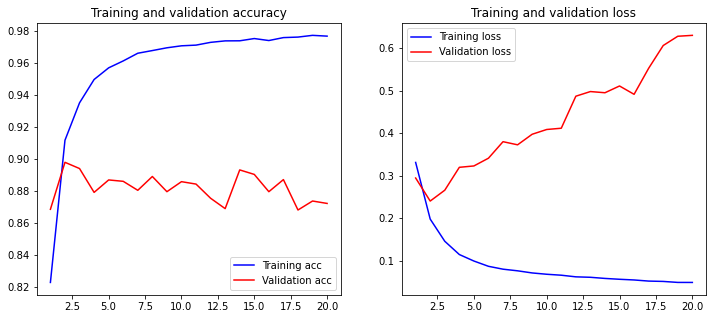

In [369]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10,class_weight={0:0.6,1:2.5})
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [373]:
predictions = model.predict(X_test.tolist())

145/145 [==============================] - 0s 635us/step


In [372]:
pred = model.predict(X_test)

145/145 [==============================] - 0s 707us/step


In [374]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [1]:
corpus = X_train
corpus_test = X_test
all_words = []
for sent in corpus:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)
all_words_test = []       
for sent in corpus_test:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words_test.append(word)

NameError: name 'X_train' is not defined

In [116]:
len(all_words)

164417

In [117]:
unique_words = set(all_words)
unique_words_t = set(all_words_test)
print(len(unique_words))

6386


In [118]:
vocab_length = len(unique_words)
vocab_length_t = len(unique_words_t)

In [204]:
embedded_sentences = [one_hot(sent, vocab_length) for sent in corpus]
embedded_sentences_t = [one_hot(sent, vocab_length_t) for sent in corpus_test]

In [120]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

In [121]:
len(word_tokenize(longest_sentence))

31

In [122]:
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
padded_sentences_t = pad_sequences(embedded_sentences_t, length_long_sentence, padding='post')
print(padded_sentences)

[[3378  221  875 ...    0    0    0]
 [1226 3999 2990 ...    0    0    0]
 [ 724 5305 3789 ...    0    0    0]
 ...
 [5335  296 5549 ...    0    0    0]
 [2935 4033 4807 ...    0    0    0]
 [ 724  296 5549 ...    0    0    0]]


In [206]:
print(padded_sentences.shape)
print(padded_sentences_t.shape)

(18512, 31)
(4629, 31)


In [209]:
model=Sequential()
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [124]:
embedding_vector_features=45
model=Sequential()
model.add(Embedding(vocab_length,embedding_vector_features,input_length=length_long_sentence))
model.add(LSTM(128,input_shape=(padded_sentences.shape),activation='relu',return_sequences=True))
model.add(Dropout(0.2))
#model.add(LSTM(128,activation='relu'))
#model.add(Dropout(0.2))
# for units in [128,128,64,32]:

# model.add(Dense(units,activation='relu'))

# model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 31, 45)            287370    
                                                                 
 lstm_4 (LSTM)               (None, 31, 128)           89088     
                                                                 
 dropout_7 (Dropout)         (None, 31, 128)           0         
                                                                 
 dense_10 (Dense)            (None, 31, 32)            4128      
                                                                 
 dropout_8 (Dropout)         (None, 31, 32)            0         
                                                                 
 dense_11 (Dense)            (None, 31, 1)             33        
                                                                 
Total params: 380,619
Trainable params: 380,619
Non-tr

In [248]:
model = Sequential()
model.add(Embedding(vocab_length, 20, input_length=length_long_sentence))
model.add(Flatten())
#model.add(Dense(120, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(units=60,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(units=15,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [264]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_length, 
                           output_dim=embedding_dim, 
                           input_length=length_long_sentence))
model.add(LSTM(128,input_shape=(padded_sentences.shape),activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 31, 50)            319300    
                                                                 
 lstm_8 (LSTM)               (None, 31, 128)           91648     
                                                                 
 dropout_15 (Dropout)        (None, 31, 128)           0         
                                                                 
 flatten_12 (Flatten)        (None, 3968)              0         
                                                                 
 dense_29 (Dense)            (None, 10)                39690     
                                                                 
 dropout_16 (Dropout)        (None, 10)                0         
                                                                 
 dense_30 (Dense)            (None, 1)               

In [256]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())
#model.compile(loss='binary_crossentropy',optimizer='adam')

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 31, 20)            127720    
                                                                 
 flatten_11 (Flatten)        (None, 620)               0         
                                                                 
 dense_28 (Dense)            (None, 1)                 621       
                                                                 
Total params: 128,341
Trainable params: 128,341
Non-trainable params: 0
_________________________________________________________________
None


In [258]:
model.fit(padded_sentences, y_train, epochs=20,verbose=1)

Epoch 1/20
579/579 [==============================] - 1s 1ms/step - loss: 0.0370 - accuracy: 0.9835
Epoch 2/20
579/579 [==============================] - 1s 1ms/step - loss: 0.0368 - accuracy: 0.9833
Epoch 3/20
579/579 [==============================] - 1s 1ms/step - loss: 0.0358 - accuracy: 0.9843
Epoch 4/20
579/579 [==============================] - 1s 1ms/step - loss: 0.0365 - accuracy: 0.9835
Epoch 5/20
579/579 [==============================] - 1s 1ms/step - loss: 0.0364 - accuracy: 0.9841
Epoch 6/20
579/579 [==============================] - 1s 1ms/step - loss: 0.0360 - accuracy: 0.9842
Epoch 7/20
579/579 [==============================] - 1s 1ms/step - loss: 0.0361 - accuracy: 0.9830
Epoch 8/20
579/579 [==============================] - 1s 1ms/step - loss: 0.0359 - accuracy: 0.9836
Epoch 9/20
579/579 [==============================] - 1s 1ms/step - loss: 0.0357 - accuracy: 0.9837
Epoch 10/20
579/579 [==============================] - 1s 1ms/step - loss: 0.0355 - accuracy: 0.9841

In [ ]:
from sklearn.utils import class_weight

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [259]:
class_weights

array([0.62162525, 2.5554942 ])

In [265]:
history = model.fit(padded_sentences, y_train,
                    epochs=12,
                    verbose=False,
                    validation_data=(padded_sentences_t, y_test),
                    batch_size=10,class_weight={0:0.6,1:2.5})
loss, accuracy = model.evaluate(padded_sentences, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(padded_sentences_t, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9538
Testing Accuracy:  0.8038


In [266]:
import matplotlib.pyplot as plt

In [267]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

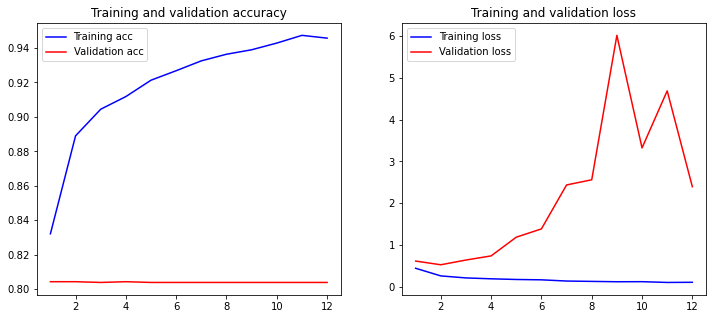

In [277]:
plot_history(history)

In [278]:
y_train

8530     0
14784    0
10216    0
8573     1
300      0
        ..
12222    0
21924    1
5453     0
881      0
16090    0
Name: PLT, Length: 18512, dtype: int64

In [279]:
loss, accuracy = model.evaluate(padded_sentences_t, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 80.384535


In [280]:
predictions_argmax = model.predict(padded_sentences_t)

145/145 [==============================] - 1s 5ms/step


In [281]:
from sklearn.metrics import classification_report,confusion_matrix

In [282]:
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      3723
           1       0.27      0.02      0.04       906

    accuracy                           0.80      4629
   macro avg       0.54      0.50      0.46      4629
weighted avg       0.70      0.80      0.72      4629

[[3669   54]
 [ 886   20]]


#### XLNet

In [342]:
#! pip uninstall torch torchvision -y
#! pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
#! pip install -U transformers
#! pip install -U simpletransformers 
# pip install torch

In [343]:
#pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113


In [344]:
# splitting the data into training and eval dataset
X = df['Avis.Pharmaceutique']
y = df['PLT']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_df = pd.DataFrame(X_train)
train_df['PLT'] = y_train

eval_df = pd.DataFrame(X_test)
eval_df['PLT'] = y_test

train_df.shape, eval_df.shape

((18512, 2), (4629, 2))

In [345]:
train_df

,Avis.Pharmaceutique,PLT
12044,gelules mg,0.0
6531,absence donnee efficacite tolerance cp ecrases...,0.0
1121,indication trouvee reevaluer necessite,1.0
1734,reference hus propose movicol dotation service lb,0.0
12951,coversyl mg perindopril mg cpr equivalence dos...,0.0
...,...,...
7607,patient esidrex hydrochlorothiazide mg cp hd,0.0
5592,fin jours ttt agnes,0.0
1470,indique atarax hydroxysine risque majore torsa...,1.0
18503,substituer gel larmes,0.0


In [346]:
from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging
import sklearn


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# They are lot of arguments to play with
'''
args = {
   'output_dir': 'outputs/',
   'cache_dir': 'cache/',
   'fp16': True,
   'fp16_opt_level': 'O1',
   'max_seq_length': 256,
   'train_batch_size': 8,
   'eval_batch_size': 8,
   'gradient_accumulation_steps': 1,
   'num_train_epochs': 3,
   'weight_decay': 0,
   'learning_rate': 4e-5,
   'adam_epsilon': 1e-8,
   'warmup_ratio': 0.06,
   'warmup_steps': 0,
   'max_grad_norm': 1.0,
   'logging_steps': 50,
   'evaluate_during_training': False,
   'save_steps': 2000,
   'eval_all_checkpoints': True,
   'use_tensorboard': True,
   'overwrite_output_dir': True,
   'reprocess_input_data': False,
}
'''



"\nargs = {\n   'output_dir': 'outputs/',\n   'cache_dir': 'cache/',\n   'fp16': True,\n   'fp16_opt_level': 'O1',\n   'max_seq_length': 256,\n   'train_batch_size': 8,\n   'eval_batch_size': 8,\n   'gradient_accumulation_steps': 1,\n   'num_train_epochs': 3,\n   'weight_decay': 0,\n   'learning_rate': 4e-5,\n   'adam_epsilon': 1e-8,\n   'warmup_ratio': 0.06,\n   'warmup_steps': 0,\n   'max_grad_norm': 1.0,\n   'logging_steps': 50,\n   'evaluate_during_training': False,\n   'save_steps': 2000,\n   'eval_all_checkpoints': True,\n   'use_tensorboard': True,\n   'overwrite_output_dir': True,\n   'reprocess_input_data': False,\n}\n"

In [347]:
import torch
torch.cuda.empty_cache()

In [348]:
torch.cuda.is_available()

True

In [349]:
torch.zeros(1).cuda()


tensor([0.], device='cuda:0')

In [362]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
model_args = ClassificationArgs(num_train_epochs=4,overwrite_output_dir=True,train_batch_size=32,max_seq_length=40)
# Create a ClassificationModel
model = ClassificationModel('xlnet', 'xlnet-base-cased', args=model_args,weight=[0.6,2.5]) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/18512 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_40_2_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

C:\Users\murat\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
C:\Users\murat\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4629 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_40_2_2


Running Evaluation:   0%|          | 0/579 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.7472234254911528, 'tp': 772, 'tn': 3466, 'fp': 257, 'fn': 134, 'auroc': 0.9656051903358337, 'auprc': 0.9045677631277477, 'acc': 0.9155325124216893, 'eval_loss': 0.30021490547617025}


In [363]:
predictions, raw_outputs = model.predict(X_test.tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4629 [00:00<?, ?it/s]

  0%|          | 0/579 [00:00<?, ?it/s]

In [ ]:
predictions

In [364]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      3723
         1.0       0.75      0.85      0.80       906

    accuracy                           0.92      4629
   macro avg       0.86      0.89      0.87      4629
weighted avg       0.92      0.92      0.92      4629

[[3466  257]
 [ 134  772]]


In [ ]:
pip list

In [ ]:
#### Without numbers

In [31]:
# Create a ClassificationModel
model = ClassificationModel("roberta", "roberta-base", args={'num_train_epochs':4, 'train_batch_size':32, 'max_seq_length':40,'overwrite_output_dir': True}) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/18512 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_40_2_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/579 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
C:\Users\murat\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4629 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Evaluation:   0%|          | 0/579 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.7573027732510283, 'tp': 700, 'tn': 3584, 'fp': 139, 'fn': 206, 'auroc': 0.9626615531755053, 'auprc': 0.8931586617957168, 'acc': 0.9254698639014906, 'eval_loss': 0.22275299306344465}


In [32]:
predictions, raw_outputs = model.predict(X_test.tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4629 [00:00<?, ?it/s]

  0%|          | 0/579 [00:00<?, ?it/s]

In [33]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3723
           1       0.83      0.77      0.80       906

    accuracy                           0.93      4629
   macro avg       0.89      0.87      0.88      4629
weighted avg       0.92      0.93      0.92      4629

[[3584  139]
 [ 206  700]]


In [79]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

X = df['Avis.Pharmaceutique']
y = df['PLT']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_df = pd.DataFrame(X_train)
train_df['PLT'] = y_train

eval_df = pd.DataFrame(X_test)
eval_df['PLT'] = y_test


# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=3,overwrite_output_dir=True)

# Create a ClassificationModel
model = ClassificationModel(
    'xlnet', 'xlnet-base-cased',
    num_labels=11,
    args=model_args
) 

# Train the model
model.train_model(train_df)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [2]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Preparing train data
train_data = [
    ["Aragorn was the heir of Isildur", 1],
    ["Frodo was the heir of Isildur", 0],
    ["Pippin is stronger than Merry", 2],
]
train_df = pd.DataFrame(train_data)
train_df.columns = ["text", "labels"]

# Preparing eval data
eval_data = [
    ["Aragorn was the heir of Elendil", 1],
    ["Sam was the heir of Isildur", 0],
    ["Merrry is stronger than Pippin", 2],
]
eval_df = pd.DataFrame(eval_data)
eval_df.columns = ["text", "labels"]

# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=1,overwrite_output_dir=True)

# Create a ClassificationModel
model = ClassificationModel(
    'bert',
    'bert-base-cased',
    num_labels=3,
    args=model_args
) 

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

# Make predictions with the model
predictions, raw_outputs = model.predict(["Sam was a Wizard"])

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/3 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_xlnet_128_3_2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\murat\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_xlnet_128_3_2


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.6123724356957946, 'eval_loss': 0.9720051884651184}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]